In [1]:
import scanpy as sc
import pandas as pd
from pathlib import Path
import anndata as ad
import numpy as np
import os

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

DPI = 300
FONTSIZE = 20  # 42

sc.settings.set_figure_params(
    scanpy=True, dpi=100, transparent=True, vector_friendly=True, dpi_save=DPI
)
from matplotlib import rcParams

rcParams["pdf.fonttype"] = 42

In [2]:
DIR2SAVE = Path("/data/BCI-CRC/nasrine/data/CRC/Primary_CRC_dataset/final_object/")

In [3]:
FIG2SAVE = DIR2SAVE.joinpath("figures/")
FIG2SAVE.mkdir(parents=True, exist_ok=True)
# set the global variable: sc.settings.figdir to save all plots
sc.settings.figdir = FIG2SAVE

### Load annotations global, raw data, subpopulation annotations

In [4]:
# load global annotation object
adata = sc.read_h5ad(
    "/data/BCI-CRC/nasrine/data/CRC/Primary_CRC_dataset/annotation_global/SMC_KUL_Pelka_Che_Wu_CRC_integrated_scvi_hvg_clustering.h5ad"
)
adata.shape

(249712, 2000)

In [5]:
# load raw counts: we also needs this for later on with spatial
adata_raw = sc.read_h5ad(
    "/data/BCI-CRC/nasrine/data/CRC/Primary_CRC_dataset/data_integration/SMC_KUL_Pelka_Che_Wu_CRC_raw.h5ad"
)

In [6]:
# load subpopulation final object (after removal of troublesome clusters)
subpopulations = ["Myeloid", "Stromal", "Endothelial", "TNKILC"]

adata_subpop_list = list()

for subpop in subpopulations:
    print(f"Loading {subpop} data ")
    adata_subpop_list.append(
        sc.read_h5ad(
            f"/data/BCI-CRC/nasrine/data/CRC/Primary_CRC_dataset/subpopulations/{subpop}/final/SMC_KUL_Pelka_Che_Wu_CRC_integrated_scvi_hvg_{subpop}_final.h5ad"
        )
    )

Loading Myeloid data 
Loading Stromal data 
Loading Endothelial data 
Loading TNKILC data 


In [7]:
adata_subpop_list[0].shape

(36906, 2000)

In [8]:
adata_subpop_list[1].shape

(5370, 2000)

In [9]:
adata_subpop_list[2].shape

(3051, 2000)

In [10]:
adata_subpop_list[3].shape

(94164, 2000)

In [11]:
# concatenate annotations from each adata subpopulation in the list adata_subpop_list
annotations = pd.concat(
    [
        adata_subpop.obs["Annotation_scVI_detailed"]
        for adata_subpop in adata_subpop_list
    ],
    axis=0,
)
annotations.shape

(139491,)

#### check number of cells is the same after concatenation 

In [12]:
assert (
    adata_subpop_list[0].shape[0]
    + adata_subpop_list[1].shape[0]
    + adata_subpop_list[2].shape[0]
    + adata_subpop_list[3].shape[0]
    == annotations.shape[0]
)

In [13]:
annotations

SMC06-T_GTGCTTCTCACCAGGC-SMC         Myeloid cycling
SMC10-T_CGTGTCTGTTAAAGTG-SMC         Myeloid cycling
SMC21-T_TACTCATCACGGCGTT-SMC         Myeloid cycling
SMC01-T_AAAGCAAGTCACTTCC-SMC                HSP Mono
SMC01-T_AAAGTAGAGGCTAGAC-SMC               NLRP3 Mac
                                          ...       
P17_Colon_T_TTGTTTGCAGCTGTCG-1-Wu         CD4 Th HSP
P17_Colon_T_TTTATGCCACTTCATT-1-Wu             CD4 Tn
P17_Colon_T_TTTCACACACACCTGG-1-Wu            CD8 Tem
P17_Colon_T_TTTCACAGTACGACTT-1-Wu             CD4 Th
P17_Colon_T_TTTCATGCACACAGAG-1-Wu             CD4 Th
Name: Annotation_scVI_detailed, Length: 139491, dtype: object

### Add annotations from subpopulations analysis to main andata object

In [14]:
adata.obs = adata.obs.merge(
    right=annotations, how="left", left_index=True, right_index=True
)

In [15]:
adata.obs

Patient       Sample         Cell_type  \
SMC01-T_AAACCTGGTCGCATAT-SMC            SMC01      SMC01-T  Epithelial cells   
SMC01-T_AAACGGGAGGGAAACA-SMC            SMC01      SMC01-T  Epithelial cells   
SMC01-T_AAAGATGAGGCCGAAT-SMC            SMC01      SMC01-T  Epithelial cells   
SMC01-T_AAAGATGTCACGACTA-SMC            SMC01      SMC01-T  Epithelial cells   
SMC01-T_AAAGATGTCCGTTGCT-SMC            SMC01      SMC01-T  Epithelial cells   
...                                       ...          ...               ...   
P17_Colon_T_TAAGCCATCTATCGCC-1-Wu  Wu2021_P17  P17_Colon_T                 B   
P17_Colon_T_TATACCTTCTAGTTCT-1-Wu  Wu2021_P17  P17_Colon_T                 B   
P17_Colon_T_TTCTGTAGTGCATTAC-1-Wu  Wu2021_P17  P17_Colon_T                 B   
P19_Colon_T_TCTAACTGTTGCTGAT-1-Wu  Wu2021_P19  P19_Colon_T                 B   
P20_Colon_T_ATCCCTGTCAAAGACA-1-Wu  Wu2021_P20  P20_Colon_T                 B   

                                           Cell_subtype Tissue Therapy  \
SMC01-T_AAACCTGGTCGCATAT-SMC                       CMS2    CRC   naive   
SMC01-T_AAACGGGAGGGAAACA-SMC                       CMS2    CRC   naive   
SMC01-T_AAAGATGAGGCCGAAT-SMC                       CMS2    CRC   naive   
SMC01-T_AAAGATGTCACGACTA-SMC                       CMS2    CRC   naive   
SMC01-T_AAAGATGTCCGTTGCT-SMC                       CMS2    CRC   naive   
...                                                 ...    ...     ...   
P17_Colon_T_TAAGCCATCTATCGCC-1-Wu  TCL1A+ Naive B cells    CRC   naive   
P17_Colon_T_TATACCTTCTAGTTCT-1-Wu  TCL1A+ Naive B cells    CRC   naive   
P17_Colon_T_TTCTGTAGTGCATTAC-1-Wu  AIM2+ Memory B cells    CRC   naive   
P19_Colon_T_TCTAACTGTTGCTGAT-1-Wu  AIM2+ Memory B cells    CRC     NAC   
P20_Colon_T_ATCCCTGTCAAAGACA-1-Wu  AIM2+ Memory B cells    CRC     NAC   

                                   doublet_score  predicted_doublet  \
SMC01-T_AAACCTGGTCGCATAT-SMC            0.089005              False   
SMC01-T_AAACGGGAGGGAAACA-SMC            0.121019              False   
SMC01-T_AAAGATGAGGCCGAAT-SMC            0.108911              False   
SMC01-T_AAAGATGTCACGACTA-SMC            0.103448              False   
SMC01-T_AAAGATGTCCGTTGCT-SMC            0.089005              False   
...                                          ...                ...   
P17_Colon_T_TAAGCCATCTATCGCC-1-Wu       0.214545              False   
P17_Colon_T_TATACCTTCTAGTTCT-1-Wu       0.171779              False   
P17_Colon_T_TTCTGTAGTGCATTAC-1-Wu       0.171779              False   
P19_Colon_T_TCTAACTGTTGCTGAT-1-Wu       0.023923              False   
P20_Colon_T_ATCCCTGTCAAAGACA-1-Wu       0.152941              False   

                                   n_genes_by_counts  total_counts  ...  \
SMC01-T_AAACCTGGTCGCATAT-SMC                    5268       33750.0  ...   
SMC01-T_AAACGGGAGGGAAACA-SMC                    1229        3752.0  ...   
SMC01-T_AAAGATGAGGCCGAAT-SMC                    3319       15662.0  ...   
SMC01-T_AAAGATGTCACGACTA-SMC                    2990       16813.0  ...   
SMC01-T_AAAGATGTCCGTTGCT-SMC                    1926        5295.0  ...   
...                                              ...           ...  ...   
P17_Colon_T_TAAGCCATCTATCGCC-1-Wu                515         880.0  ...   
P17_Colon_T_TATACCTTCTAGTTCT-1-Wu                532        1056.0  ...   
P17_Colon_T_TTCTGTAGTGCATTAC-1-Wu                757        1686.0  ...   
P19_Colon_T_TCTAACTGTTGCTGAT-1-Wu                642        1457.0  ...   
P20_Colon_T_ATCCCTGTCAAAGACA-1-Wu                389         718.0  ...   

                                   cell_source  _scvi_batch  _scvi_labels  \
SMC01-T_AAACCTGGTCGCATAT-SMC               SMC            0             0   
SMC01-T_AAACGGGAGGGAAACA-SMC               SMC            0             0   
SMC01-T_AAAGATGAGGCCGAAT-SMC               SMC            0             0   
SMC01-T_AAAGATGTCACGACTA-SMC               SMC            0             0   
SMC01-T_AAAGATGTCCGTTGCT-SMC               SMC   

In [16]:
adata.obs.Annotation_scVI_detailed = np.where(
    adata.obs.Annotation_scVI_detailed.isna(),  # where NaN values in detailed annot
    adata.obs.Annotation_scVI,  # put general annotations
    adata.obs.Annotation_scVI_detailed,
)  # keep detailed annotations

adata.obs.Annotation_scVI_detailed = adata.obs.Annotation_scVI_detailed.astype(
    "category"
)

In [17]:
adata.obs[50000:]

Patient              Sample  \
C104_T_1_1_3_c1_v2_id-CACATAGAGTGCTGCC-Pelka      C104_T  C104_T_1_1_3_c1_v2   
C104_T_1_1_3_c1_v2_id-CACATAGGTAATCACC-Pelka      C104_T  C104_T_1_1_3_c1_v2   
C104_T_1_1_3_c1_v2_id-CACATAGTCTGCCAGG-Pelka      C104_T  C104_T_1_1_3_c1_v2   
C104_T_1_1_3_c1_v2_id-CACATTTTCTAACCGA-Pelka      C104_T  C104_T_1_1_3_c1_v2   
C104_T_1_1_3_c1_v2_id-CACCACTGTTCTGGTA-Pelka      C104_T  C104_T_1_1_3_c1_v2   
...                                                  ...                 ...   
P17_Colon_T_TAAGCCATCTATCGCC-1-Wu             Wu2021_P17         P17_Colon_T   
P17_Colon_T_TATACCTTCTAGTTCT-1-Wu             Wu2021_P17         P17_Colon_T   
P17_Colon_T_TTCTGTAGTGCATTAC-1-Wu             Wu2021_P17         P17_Colon_T   
P19_Colon_T_TCTAACTGTTGCTGAT-1-Wu             Wu2021_P19         P19_Colon_T   
P20_Colon_T_ATCCCTGTCAAAGACA-1-Wu             Wu2021_P20         P20_Colon_T   

                                             Cell_type  \
C104_T_1_1_3_c1_v2_id-CACATAGAGTGCTGCC-Pelka       Epi   
C104_T_1_1_3_c1_v2_id-CACATAGGTAATCACC-Pelka    TNKILC   
C104_T_1_1_3_c1_v2_id-CACATAGTCTGCCAGG-Pelka    TNKILC   
C104_T_1_1_3_c1_v2_id-CACATTTTCTAACCGA-Pelka         B   
C104_T_1_1_3_c1_v2_id-CACCACTGTTCTGGTA-Pelka    TNKILC   
...                                                ...   
P17_Colon_T_TAAGCCATCTATCGCC-1-Wu                    B   
P17_Colon_T_TATACCTTCTAGTTCT-1-Wu                    B   
P17_Colon_T_TTCTGTAGTGCATTAC-1-Wu                    B   
P19_Colon_T_TCTAACTGTTGCTGAT-1-Wu                    B   
P20_Colon_T_ATCCCTGTCAAAGACA-1-Wu                    B   

                                                          Cell_subtype Tissue  \
C104_T_1_1_3_c1_v2_id-CACATAGAGTGCTGCC-Pelka    cE06 (Immature Goblet)    CRC   
C104_T_1_1_3_c1_v2_id-CACATAGGTAATCACC-Pelka        cTNI11 (CD8+GZMK+)    CRC   
C104_T_1_1_3_c1_v2_id-CACATAGTCTGCCAGG-Pelka  cTNI02 (CD4+ IL7R+SELL+)    CRC   
C104_T_1_1_3_c1_v2_id-CACATTTTCTAACCGA-Pelka     cB3 (B CD40+ GC-like)    CRC   
C104_T_1_1_3_c1_v2_id-CACCACTGTTCTGGTA-Pelka   cTNI03 (CD4+ IL7R+HSP+)    CRC   
...                                                                ...    ...   
P17_Colon_T_TAAGCCATCTATCGCC-1-Wu                 TCL1A+ Naive B cells    CRC   
P17_Colon_T_TATACCTTCTAGTTCT-1-Wu                 TCL1A+ Naive B cells    CRC   
P17_Colon_T_TTCTGTAGTGCATTAC-1-Wu                 AIM2+ Memory B cells    CRC   
P19_Colon_T_TCTAACTGTTGCTGAT-1-Wu                 AIM2+ Memory B cells    CRC   
P20_Colon_T_ATCCCTGTCAAAGACA-1-Wu                 AIM2+ Memory B cells    CRC   

                                             Therapy  doublet_score  \
C104_T_1_1_3_c1_v2_id-CACATAGAGTGCTGCC-Pelka   naive       0.085246   
C104_T_1_1_3_c1_v2_id-CACATAGGTAATCACC-Pelka   naive       0.157635   
C104_T_1_1_3_c1_v2_id-CACATAGTCTGCCAGG-Pelka   naive       0.044811   
C104_T_1_1_3_c1_v2_id-CACATTTTCTAACCGA-Pelka   naive       0.085246   
C104_T_1_1_3_c1_v2_id-CACCACTGTTCTGGTA-Pelka   naive       0.044811   
...                                              ...            ...   
P17_Colon_T_TAAGCCATCTATCGCC-1-Wu              naive       0.214545   
P17_Colon_T_TATACCTTCTAGTTCT-1-Wu              naive       0.171779   
P17_Colon_T_TTCTGTAGTGCATTAC-1-Wu              naive       0.171779   
P19_Colon_T_TCTAACTGTTGCTGAT-1-Wu                NAC       0.023923   
P20_Colon_T_ATCCCTGTCAAAGACA-1-Wu                NAC       0.152941   

                                              predicted_doublet  \
C104_T_1_1_3_c1_v2_id-CACATAGAGTGCTGCC-Pelka              False   
C104_T_1_1_3_c1_v2_id-CACATAGGTAATCACC-Pelka              False   
C104_T_1_1_3_c1_v2_id-CACATAGTCTGCCAGG-Pelka              False   
C104_T_1_1_3_c1_v2_id-CACATTTTCTAACCGA-Pelka              False   
C104_T_1_1_3_c1_v2_id-CACCACTGTTCTGGTA-Pelka              False   
...                                                         ...   
P17_Colon_T_TAAGCCATCTATCGCC-1-Wu                         False   
P17_Colon_T_TATACCTTCTAGTTCT-

In [18]:
adata.obs.Annotation_scVI_detailed.value_counts()

Epithelial         50060
Plasma             24978
B                  19703
CD8 Tex            13813
CD4 Tn             12862
CD8 Tem            10033
Treg                9747
CD4 Th              8345
Treg HSP            7770
SPP1 Mac            7017
T-NK-ILC            6896
C1QC Mac            6449
CD4 Th17            6170
T cycling           5220
gdT                 4972
FCN1 Mono           4685
Myeloid             4131
CD4 Th HSP          3611
CD4 Tfh             3470
NK2                 2840
FCGR3A Mono         2697
cDC2                2664
Mast                2588
CD8 Tem HSP         2306
Myeloid cycling     2166
PLTP LYVE1 Mac      2150
NLRP3 Mac           1887
HSP Mono            1755
IL1B Mac            1457
NKT                 1449
pDC                 1423
Stalk-like endo     1382
Tip-like endo       1326
Stromal             1257
migDC               1159
NK1                 1088
Pericyte            1073
Neutrophil          1054
Myofibroblast        872
C3 iCAF              750


### remove cells we discarded in the analysis because of doublets, etc.. by removing cells that have general cell population label in column `Annotation_scVI_detailed`: Myeloid, T-NK-ILC, Stromal, Endothelial

In [19]:
adata = adata[
    ~adata.obs.Annotation_scVI_detailed.isin(
        ["Myeloid", "T-NK-ILC", "Stromal", "Endothelial"]
    )
].copy()

In [20]:
adata.shape

(236820, 2000)

In [21]:
# check if we get same number of cells from subclustering TME analysis
adata[
    ~adata.obs.Annotation_scVI_detailed.isin(["Epithelial", "B", "Plasma", "Mast"])
].shape

(139491, 2000)

In [22]:
adata.obs.Annotation_scVI_detailed.value_counts()

Epithelial         50060
Plasma             24978
B                  19703
CD8 Tex            13813
CD4 Tn             12862
CD8 Tem            10033
Treg                9747
CD4 Th              8345
Treg HSP            7770
SPP1 Mac            7017
C1QC Mac            6449
CD4 Th17            6170
T cycling           5220
gdT                 4972
FCN1 Mono           4685
CD4 Th HSP          3611
CD4 Tfh             3470
NK2                 2840
FCGR3A Mono         2697
cDC2                2664
Mast                2588
CD8 Tem HSP         2306
Myeloid cycling     2166
PLTP LYVE1 Mac      2150
NLRP3 Mac           1887
HSP Mono            1755
IL1B Mac            1457
NKT                 1449
pDC                 1423
Stalk-like endo     1382
Tip-like endo       1326
migDC               1159
NK1                 1088
Pericyte            1073
Neutrophil          1054
Myofibroblast        872
C3 iCAF              750
CXCL14 BMP CAF       737
GREM1 HSP CAF        662
MMP CAF              632


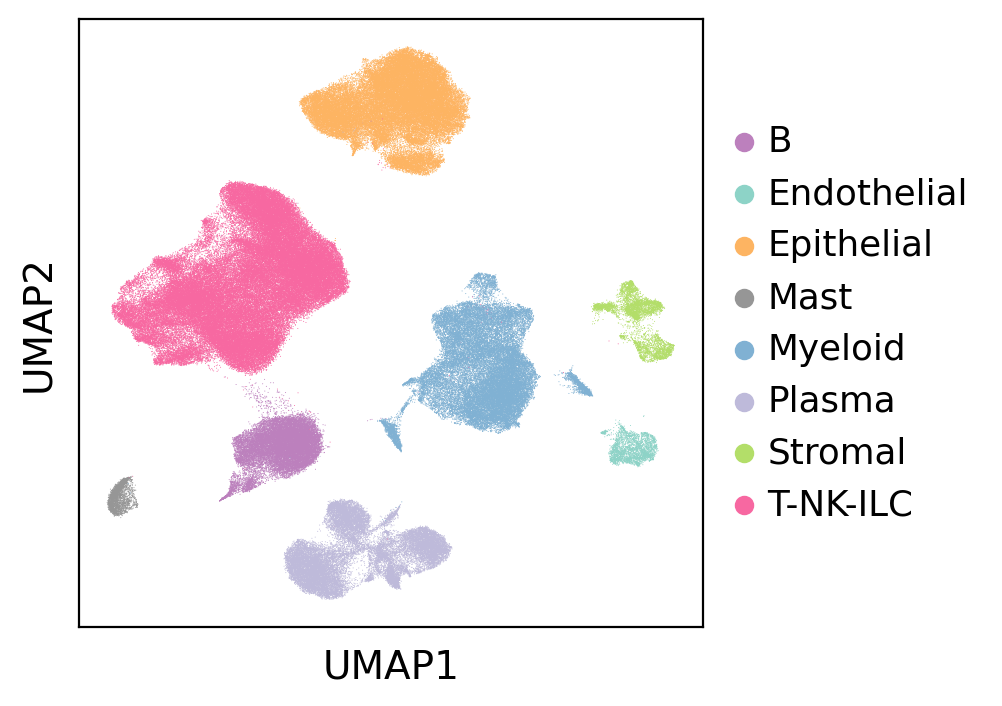

In [23]:
sc.pl.umap(adata, color="Annotation_scVI", save="Annotations_global.pdf", title="")

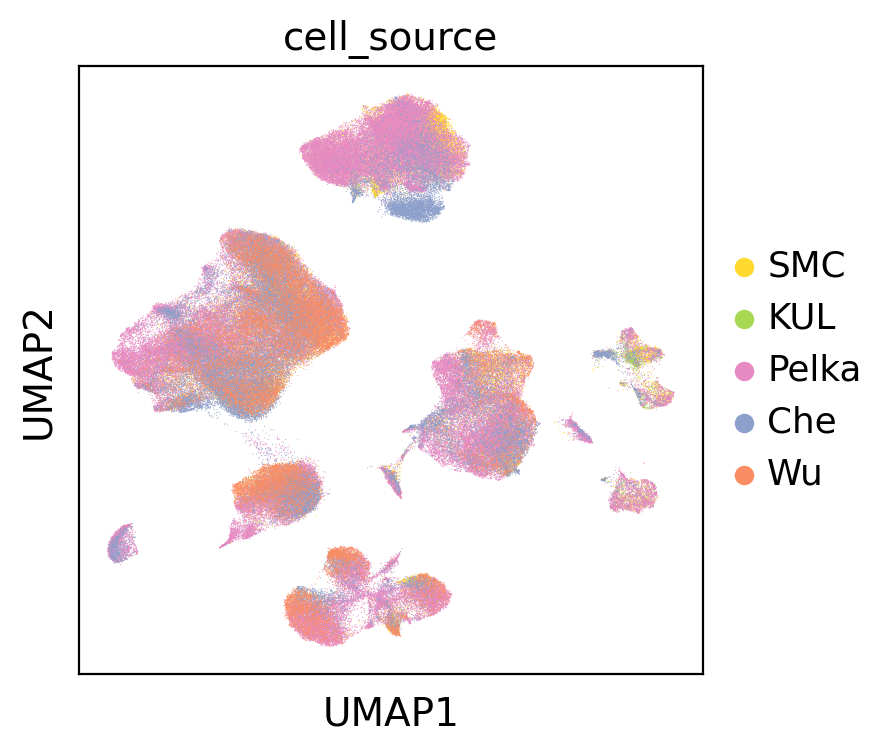

In [24]:
sc.pl.umap(adata, color="cell_source", save="cell_source_global.pdf")

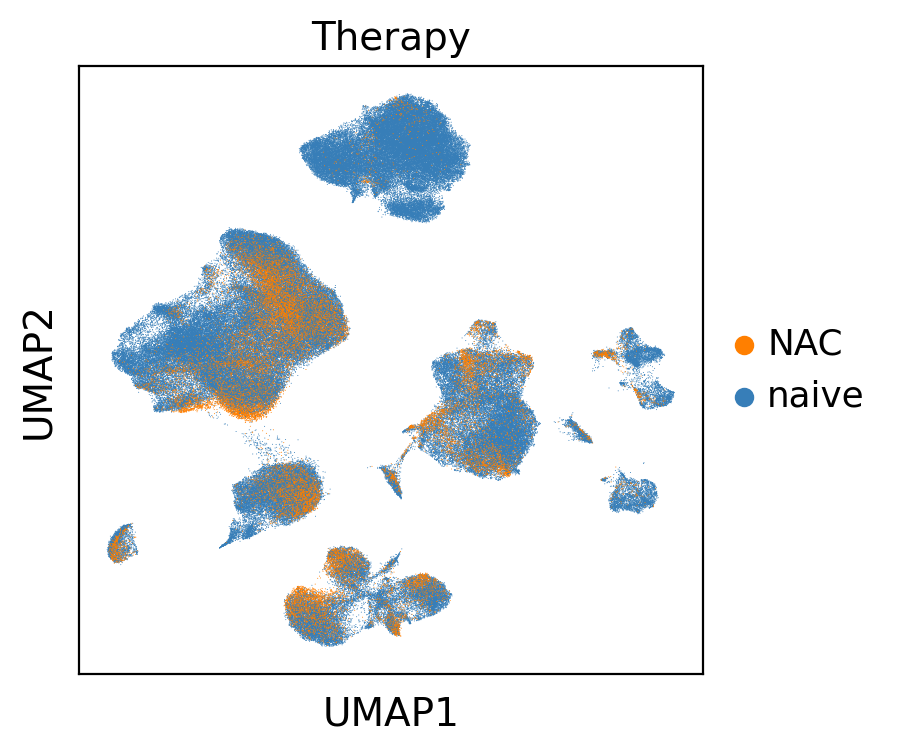

In [25]:
sc.pl.umap(adata, color="Therapy", save="therapy_global.pdf")

In [28]:
adata.obs.Annotation_scVI_detailed.cat.categories.tolist()

['B',
 'C1QC Mac',
 'C3 iCAF',
 'CD4 Tfh',
 'CD4 Th',
 'CD4 Th HSP',
 'CD4 Th17',
 'CD4 Tn',
 'CD8 Tem',
 'CD8 Tem HSP',
 'CD8 Tex',
 'CXCL14 BMP CAF',
 'Endo cycling',
 'Enteric glial',
 'Epithelial',
 'FCGR3A Mono',
 'FCN1 Mono',
 'GREM1 HSP CAF',
 'HSP Mono',
 'IL1B Mac',
 'ILC3',
 'Lymphatic endo',
 'MMP CAF',
 'Mast',
 'Myeloid cycling',
 'Myofibroblast',
 'NK1',
 'NK2',
 'NKT',
 'NLRP3 Mac',
 'Neutrophil',
 'PLTP LYVE1 Mac',
 'Pericyte',
 'Plasma',
 'SMC',
 'SPP1 Mac',
 'Stalk-like endo',
 'Stromal cycling',
 'T cycling',
 'Tip-like endo',
 'Treg',
 'Treg HSP',
 'cDC1',
 'cDC2',
 'gdT',
 'migDC',
 'pDC']

In [29]:
adata.uns["Annotation_scVI_detailed_colors"] = [
    "#bc80bd",
    "#80b1d3",
    "#41ab5d",
    "#1f78b4",
    "#fa9fb5",
    "#beaed4",
    "#fdbf6f",
    "#b15928",
    "#e31a1c",
    "#800026",
    "#ff7f00",
    "#993404",
    "#fee391",
    "#fdd0a2",
    "#fdb462",
    "#e5d8bd",
    "#b3de69",
    "#d94801",
    "#e31a1c",
    "#fb8072",
    "#cab2d6",
    "#66c2a5",
    "#fec44f",
    "#969696",
    "#ffff99",
    "#fc8d59",
    "#1d91c0",
    "#dd3497",
    "#a6cee3",
    "#fdb462",
    "#1f78b4",
    "#fccde5",
    "#addd8e",
    "#bebada",
    "#feb24c",
    "#8dd3c7",
    "#e78ac3",
    "#fee391",
    "#ffff99",
    "#fc8d62",
    "#33a02c",
    "#b2df8a",
    "#bc80bd",
    "#bebada",
    "#6a3d9a",
    "#762a83",
    "#fa9fb5",
]

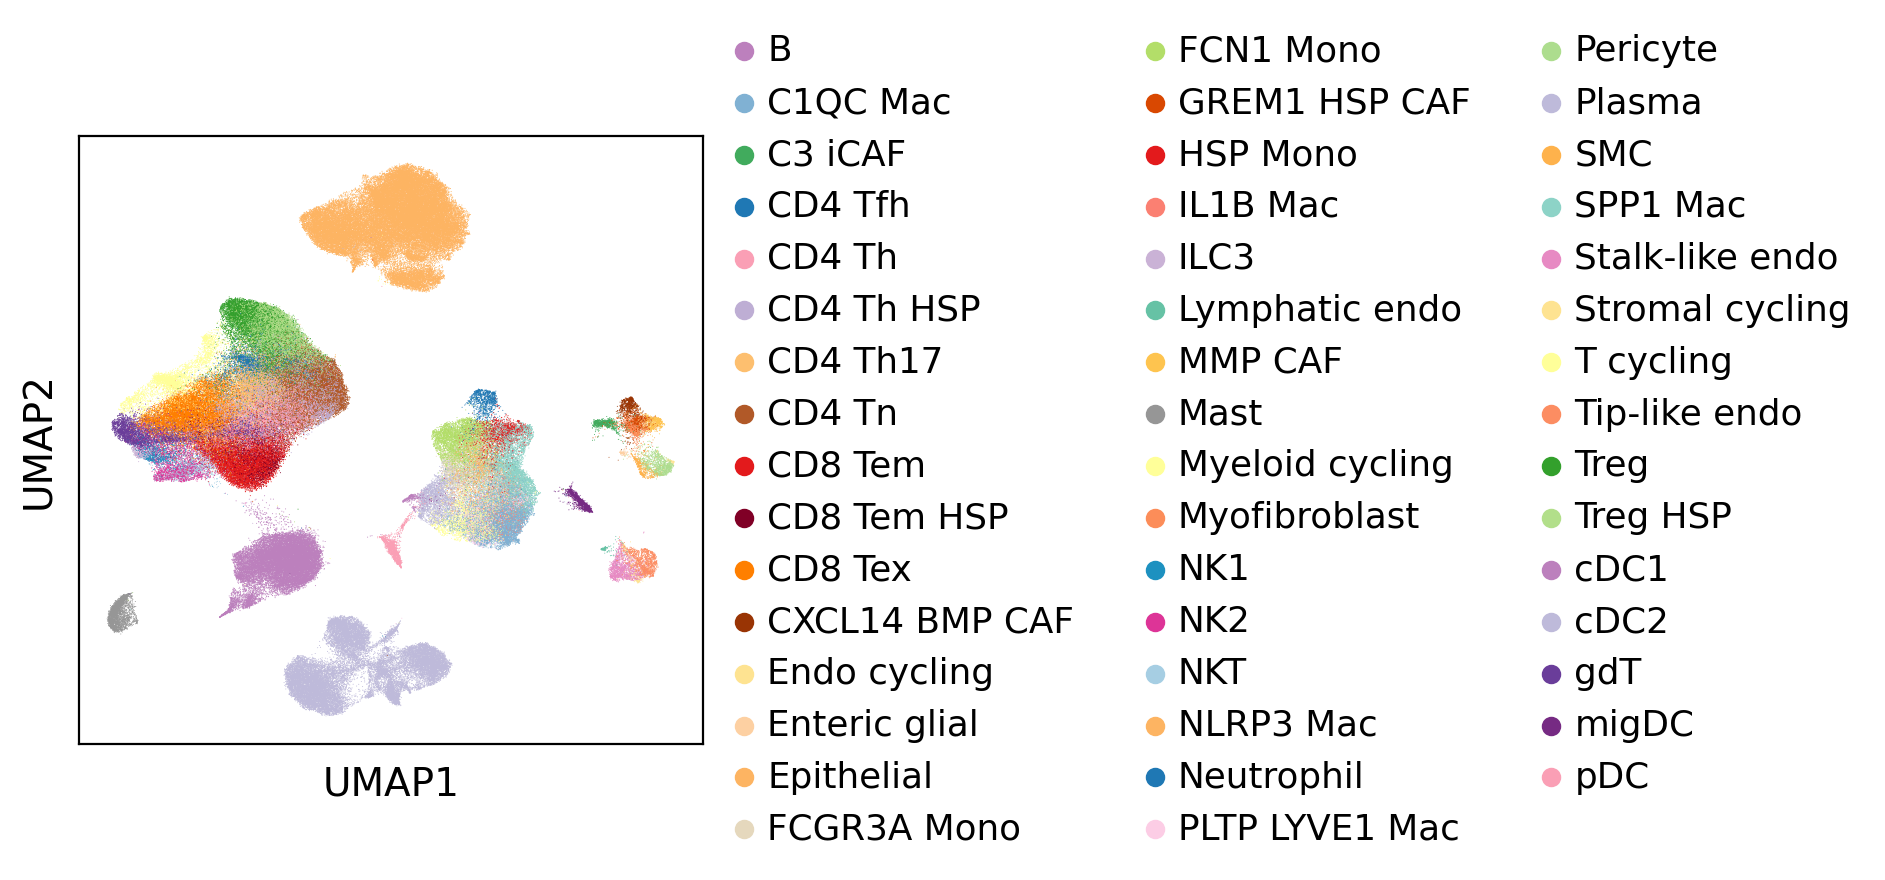

In [30]:
sc.pl.umap(
    adata, color="Annotation_scVI_detailed", title="", save="annotations_detailed.pdf"
)

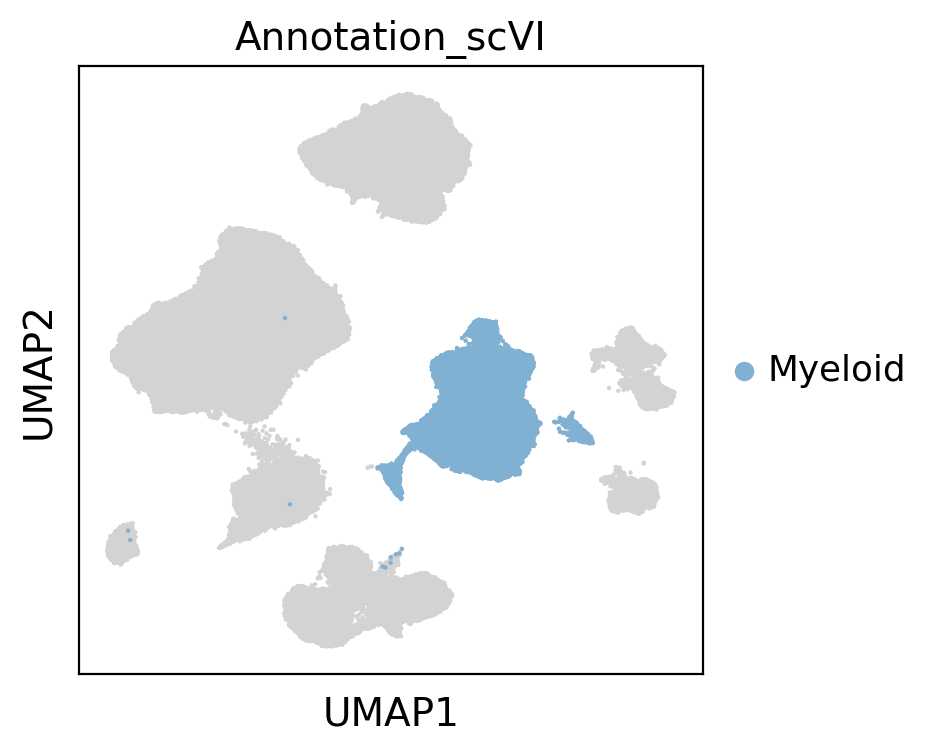

In [31]:
###
ax = sc.pl.umap(adata, size=10, show=False)
sc.pl.umap(
    adata[adata.obs["Annotation_scVI"] == "Myeloid"],
    size=10,
    color="Annotation_scVI",
    ax=ax,
)

### plot proportion per cell type

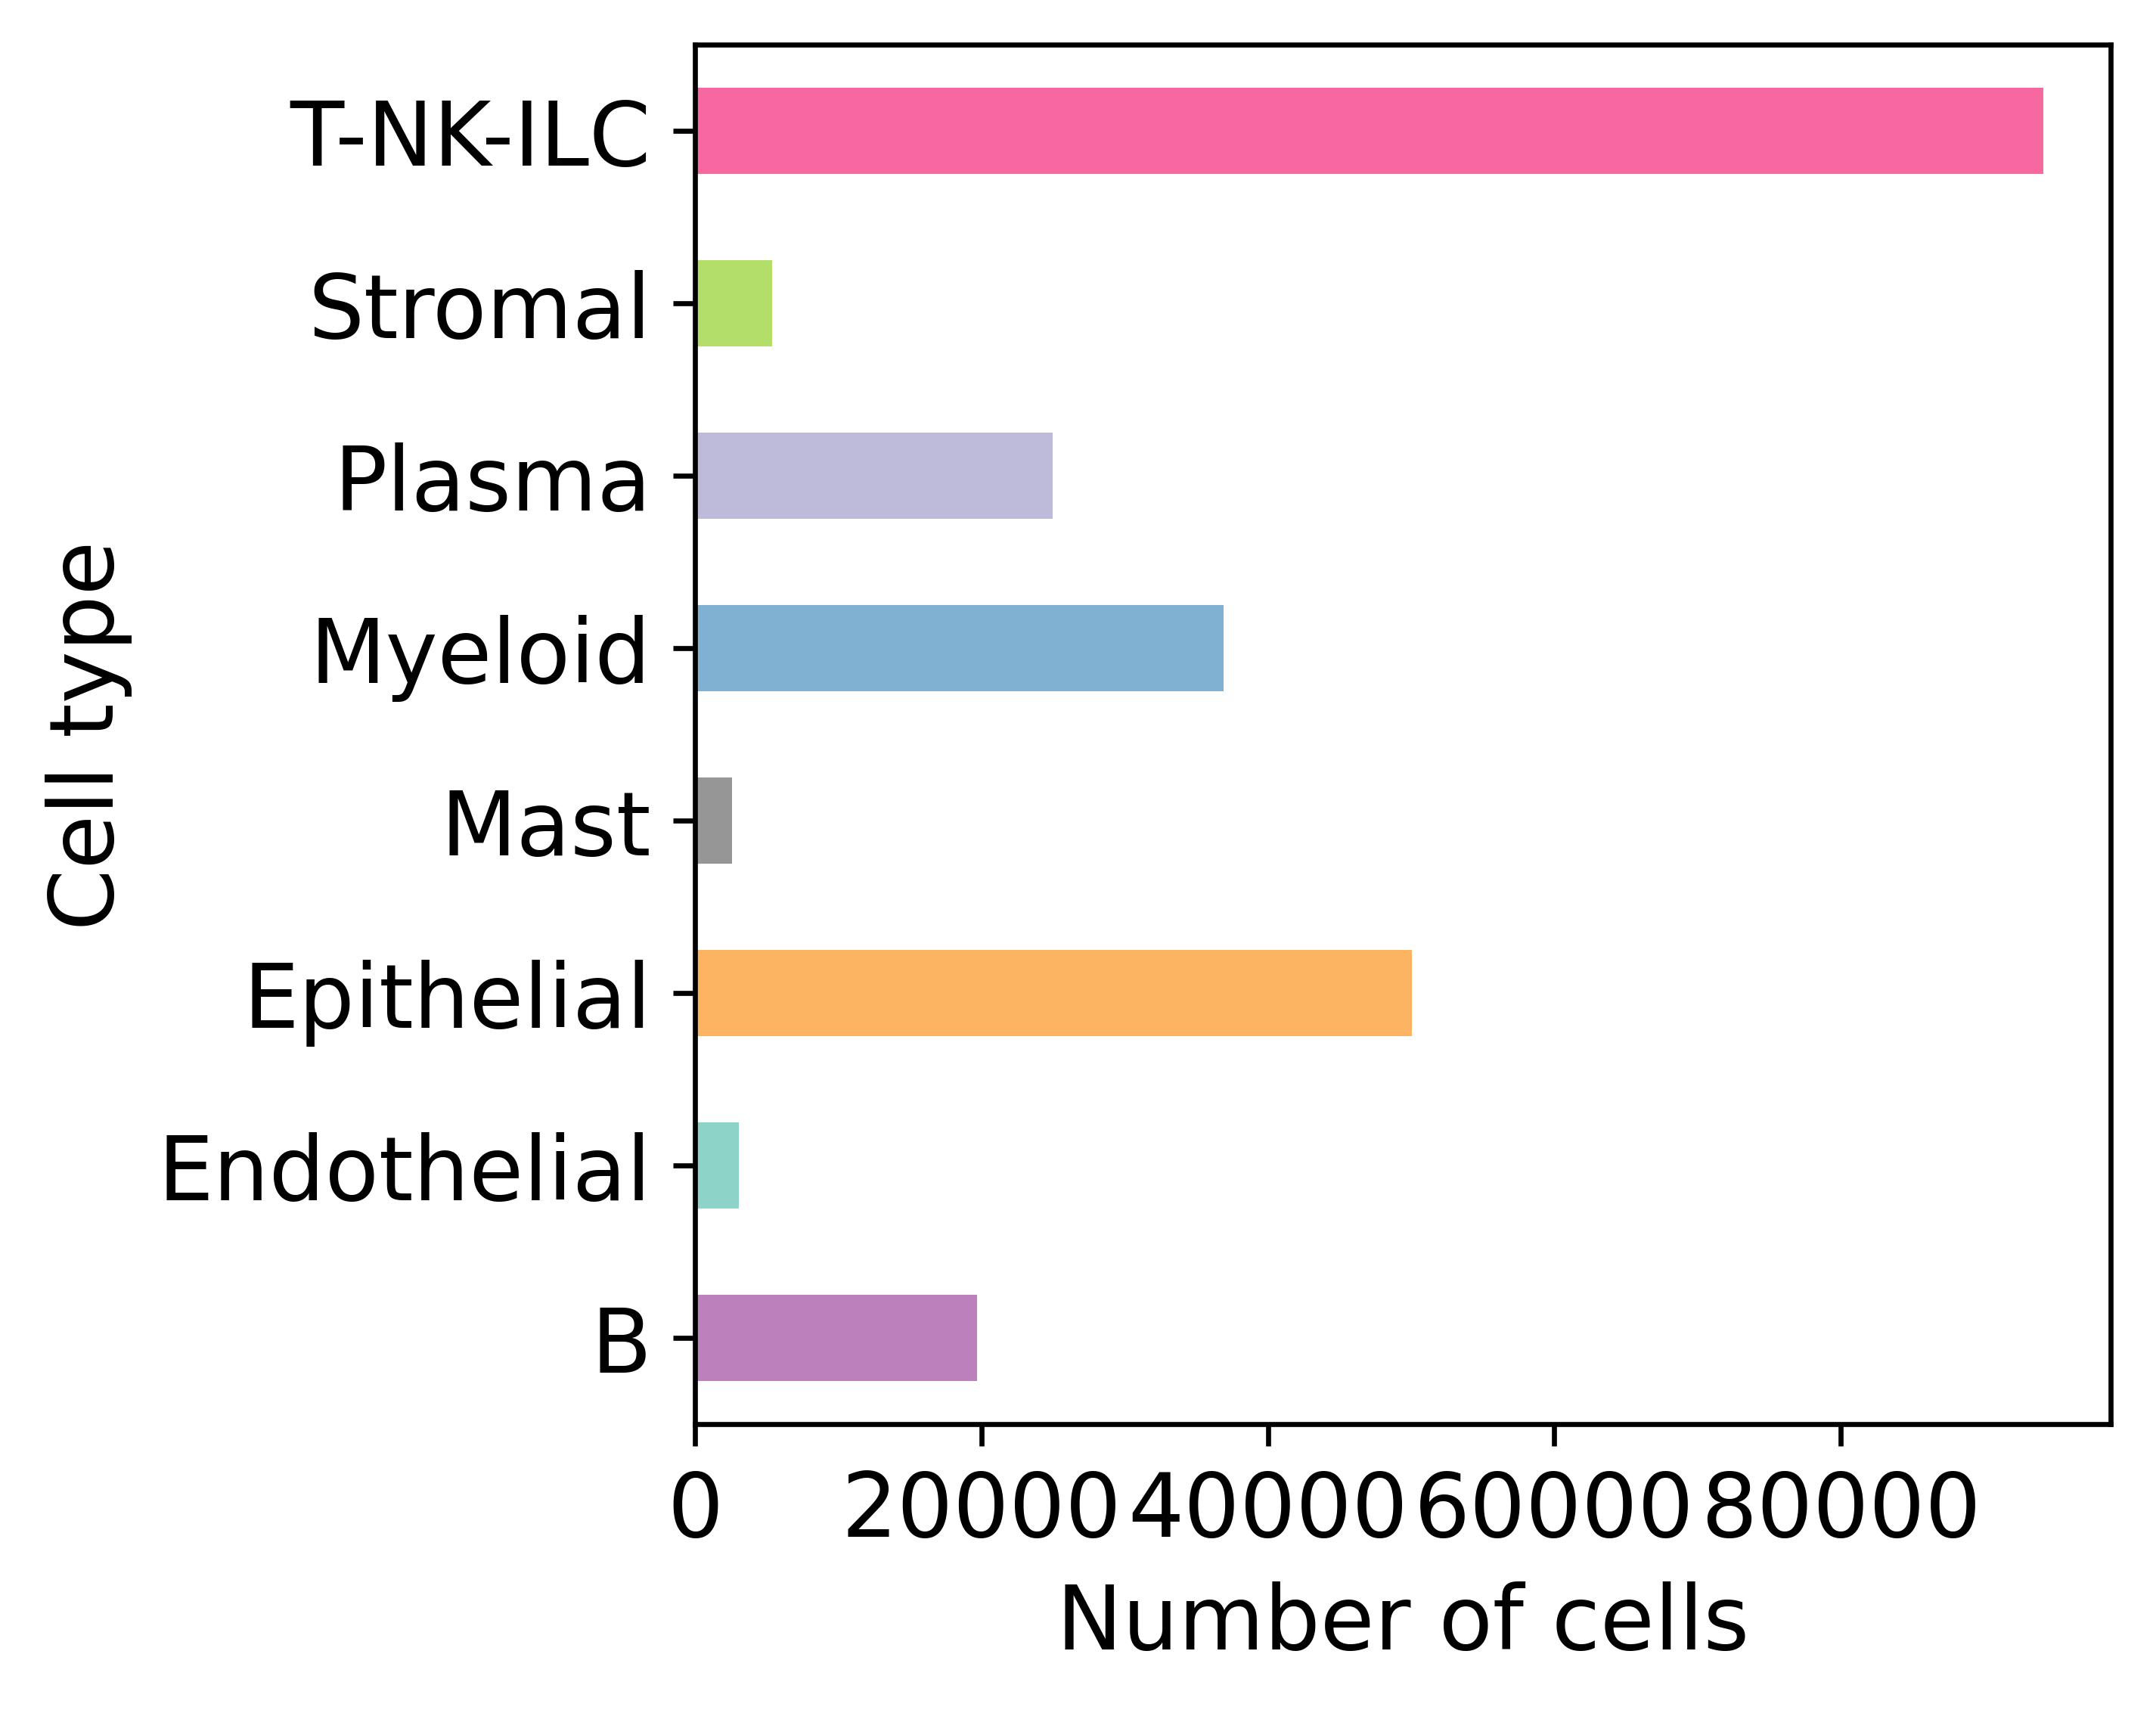

In [32]:
from collections import OrderedDict

color_dict = OrderedDict(
    zip(
        adata.obs["Annotation_scVI"].cat.categories.values.tolist(),
        adata.uns["Annotation_scVI_colors"],
    )
)

fig, ax = plt.subplots(nrows=1, ncols=1, sharey=False, sharex=False, dpi=DPI)
adata.obs.groupby("Annotation_scVI").size().plot.barh(color=color_dict.values(), ax=ax)
ax.set_ylabel("Cell type")
ax.set_xlabel("Number of cells")
ax.grid(False, which="major", axis="both")  # removes major horizontal gridlinesd
plt.savefig(FIG2SAVE.joinpath("barplot_nb_cells_celltype.pdf"))

In [33]:
markers = {
    "Epithelial": ["EPCAM", "CDH1"],
    "Myeloid": ["CD68", "CD14"],
    "Kupffer": ["SLC11A1", "CD5L", "TIMD4", "CETP"],
    "Granulocyte": ["CPA3", "GATA2", "TPSAB1"],
    "Neutrophil": [
        "FCGR3B",
        "S100A8",
        "S100A12",
        "MPO",
        "ELANE",
        "DEFA4",
        "DEFA3",
        "CEACAM6",
    ],
    "Stromal": ["DCN", "VCAM1", "COL1A1", "COL3A1"],
    "Endothelial": ["PECAM1", "CDH5", "LYVE1"],
    "T/NK/ILC": ["TRAC", "CD3D", "CD3E", "CD3G", "KLRB1", "GZMB"],
    "NK": ["EOMES", "CMC1", "GZMK", "XCL1", "NKG7", "PRF1", "NCR1", "NCAM1", "FCER1G"],
    "ILC": ["AREG", "TLE1", "IL4I1"],
    "Mast": ["KIT", "TPSAB1", "TPSB2", "MS4A2"],
    "B": ["CD79A", "MS4A1"],
    "Plasma B": ["SDC1", "MZB1"],
    # "Hepatocyte": ["ALB", "TTR", "APOA1", "AFP"],
    # "Cholangiocyte": ["SOX9", "EPCAM", "KRT19", "CLDN4", "CLDN10", "FXYD2"],
    "DC": ["FCER1A", "PKIB", "CD1C", "PCLAF", "CLEC10A", "CES1"],
}

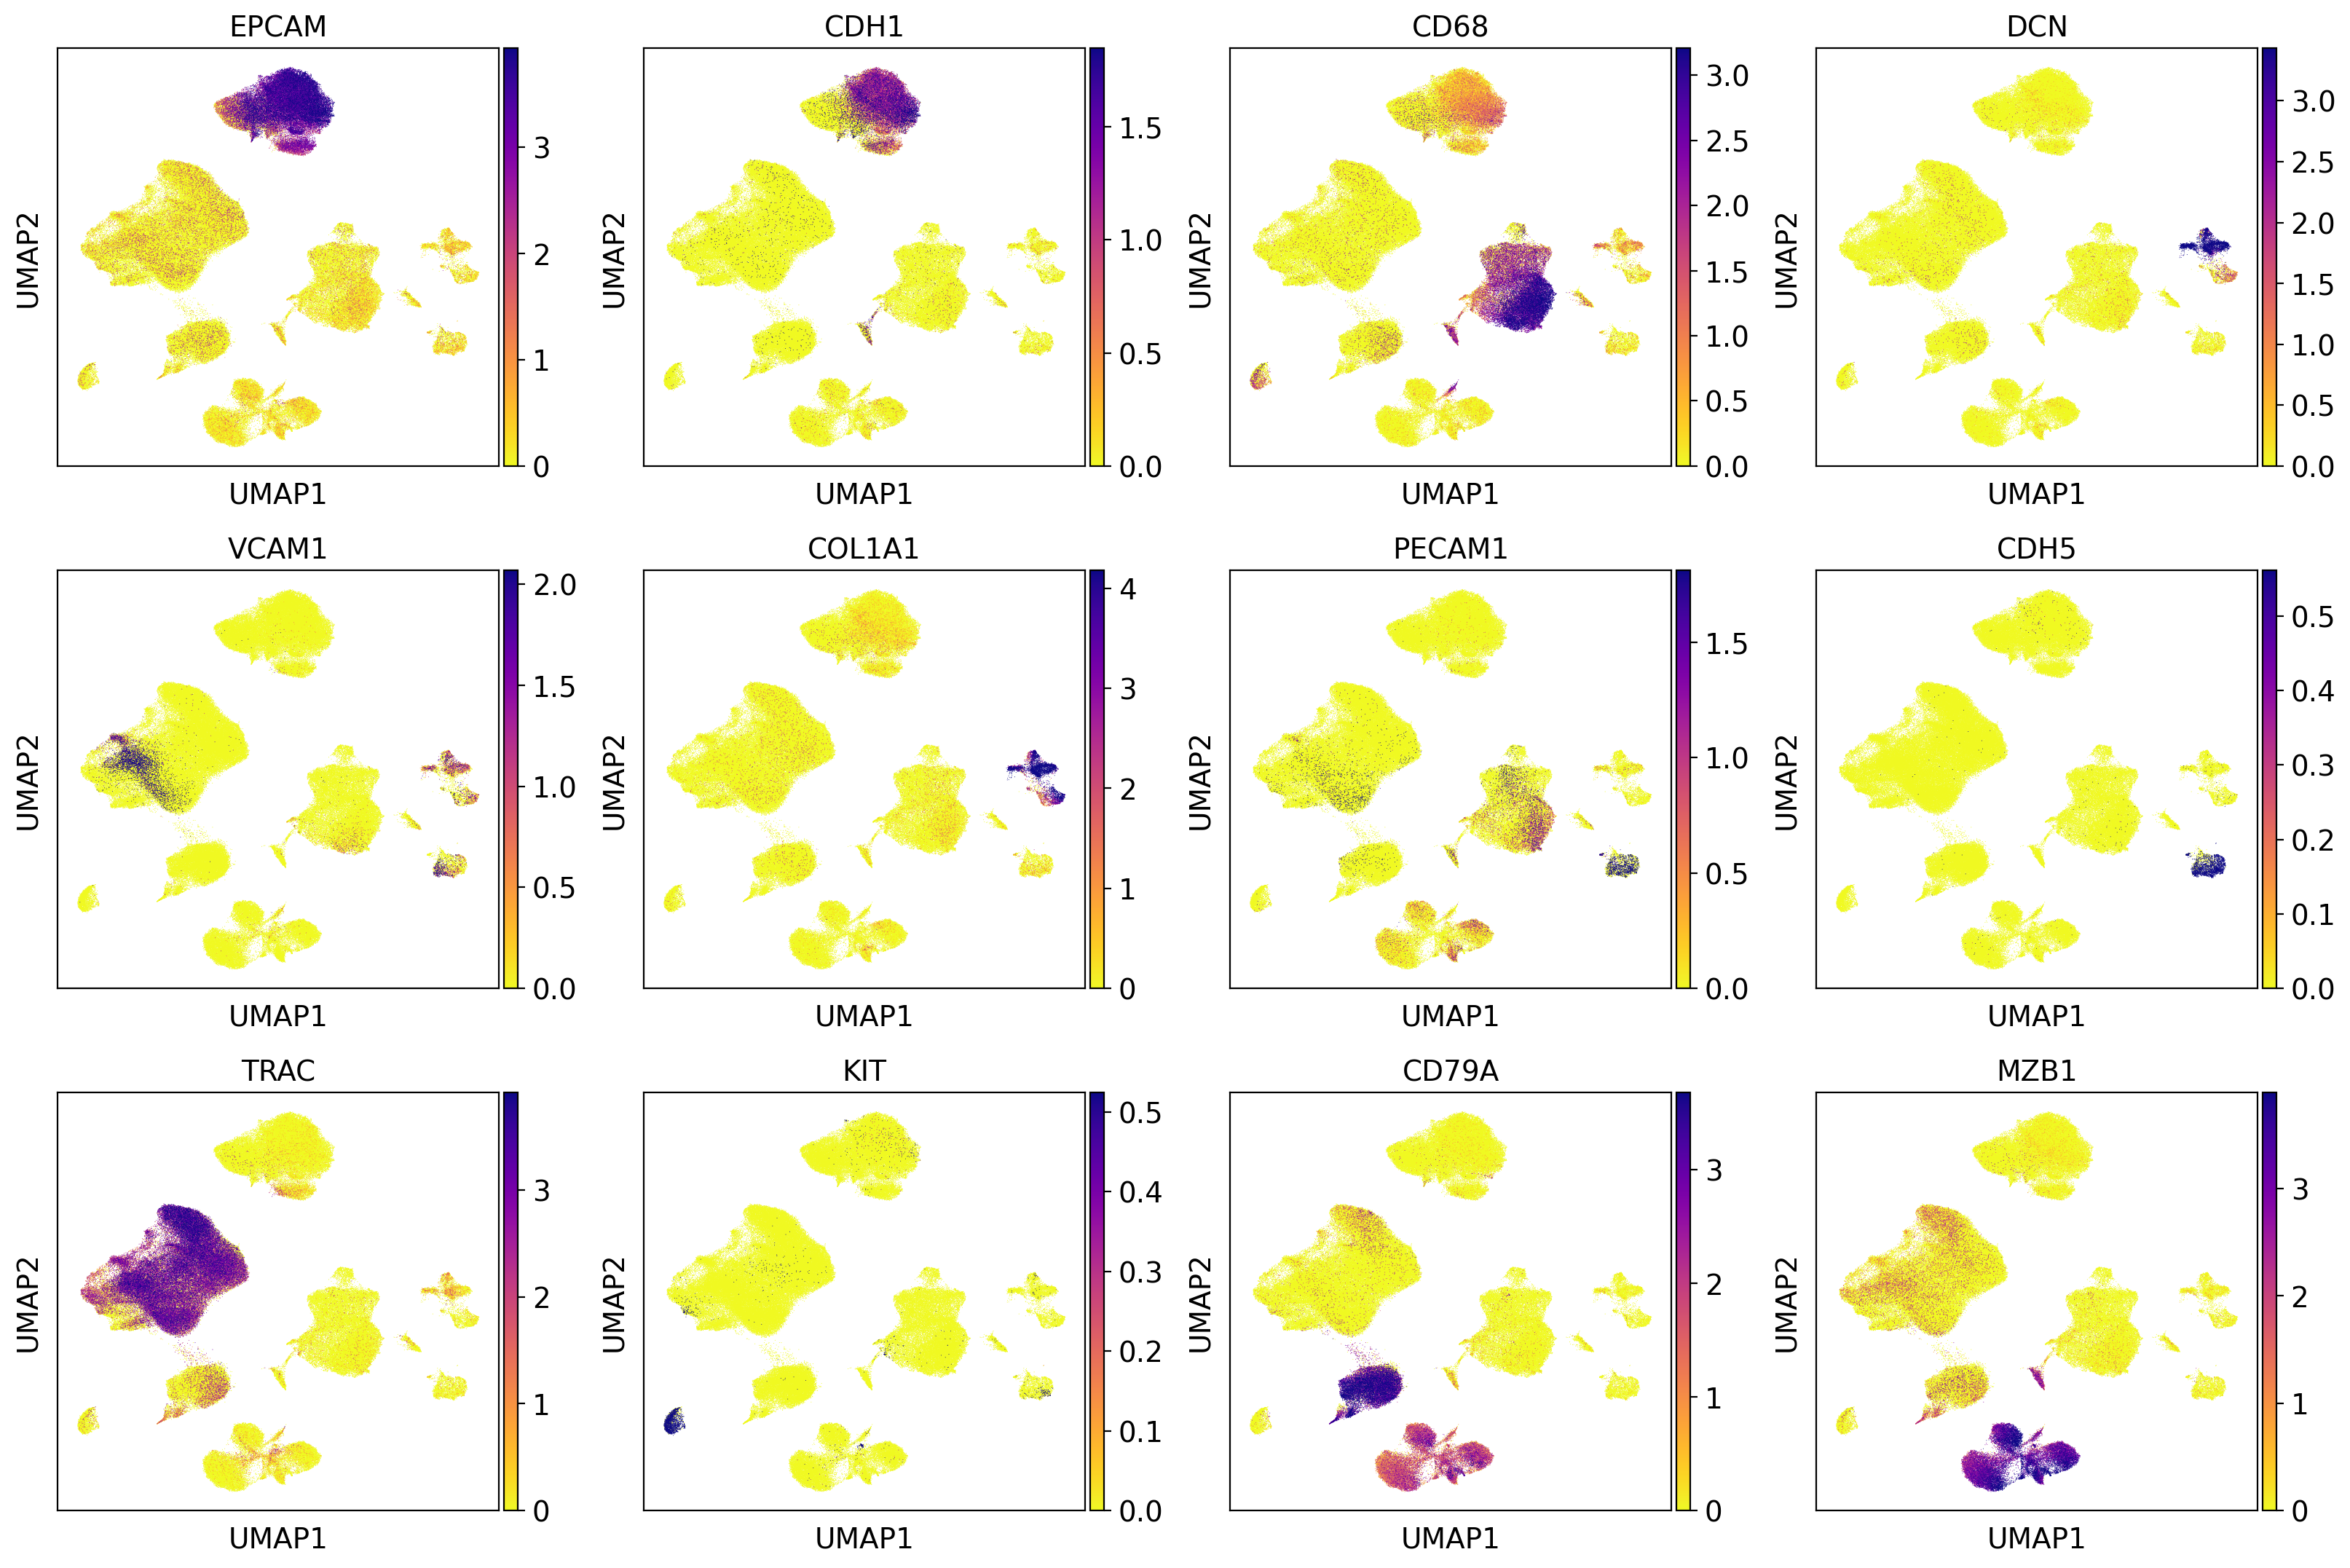

In [34]:
marker_subset = [
    "EPCAM",
    "CDH1",
    "CD68",
    "DCN",
    "VCAM1",
    "COL1A1",
    "PECAM1",
    "CDH5",
    "TRAC",
    "KIT",
    "CD79A",
    "MZB1",
]
sc.pl.umap(
    adata,
    color=marker_subset,
    use_raw=True,
    vmin=0.0,
    vmax="p99",
    color_map="plasma_r",
    save="general_markers_major_celltypes.pdf",
    show=True,
)

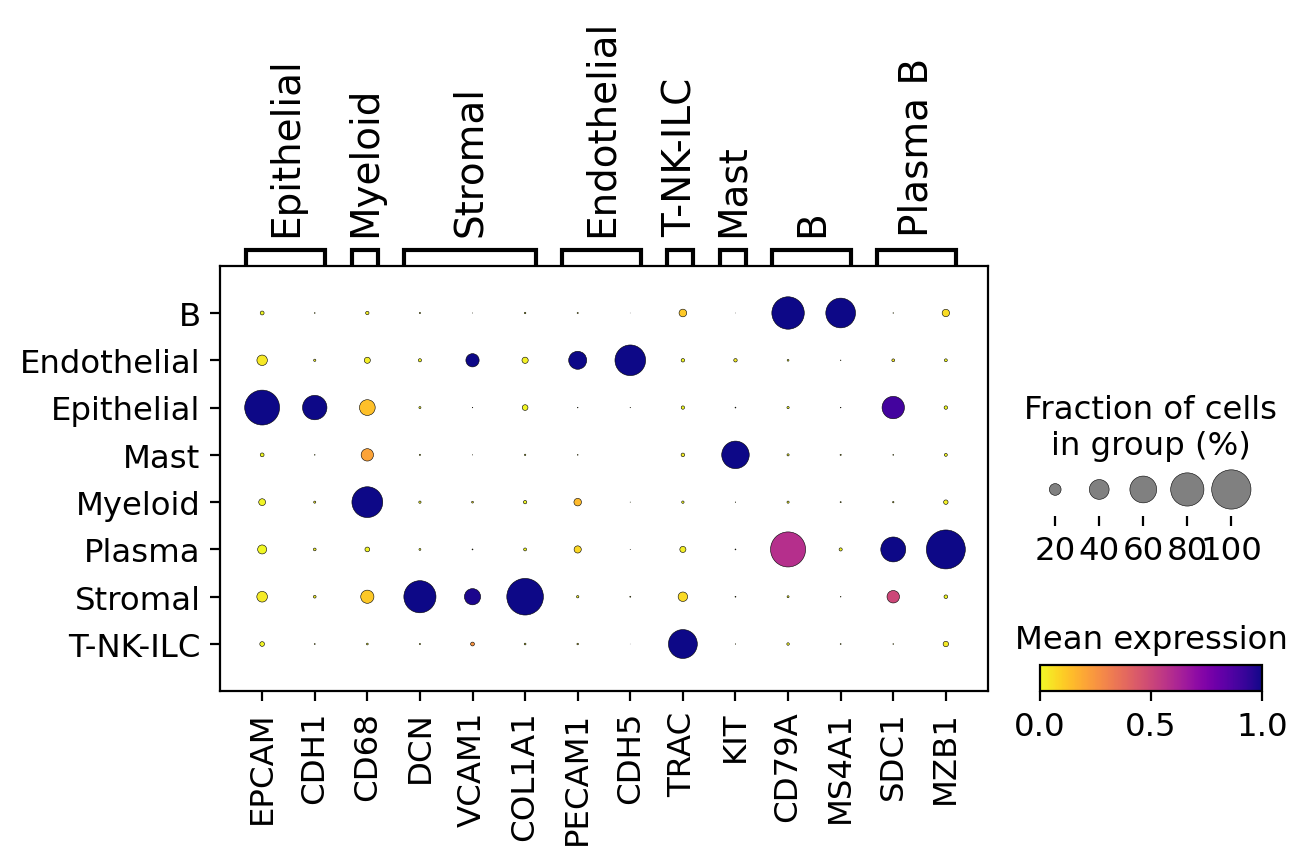

In [36]:
markers_short_list = {
    "Epithelial": ["EPCAM", "CDH1"],
    "Myeloid": ["CD68"],
    "Stromal": ["DCN", "VCAM1", "COL1A1"],
    "Endothelial": ["PECAM1", "CDH5"],
    "T-NK-ILC": ["TRAC"],
    "Mast": ["KIT"],
    "B": ["CD79A", "MS4A1"],
    "Plasma B": ["SDC1", "MZB1"],
}

sc.pl.dotplot(
    adata,
    groupby="Annotation_scVI",
    use_raw=True,
    var_names=markers_short_list,
    cmap="plasma_r",
    standard_scale="var",
    vmin=0,
    vmax=1,
    colorbar_title="Mean expression",
    dendrogram=False,
    save="dotplot_mean_general_short.pdf",
    show=True,
)

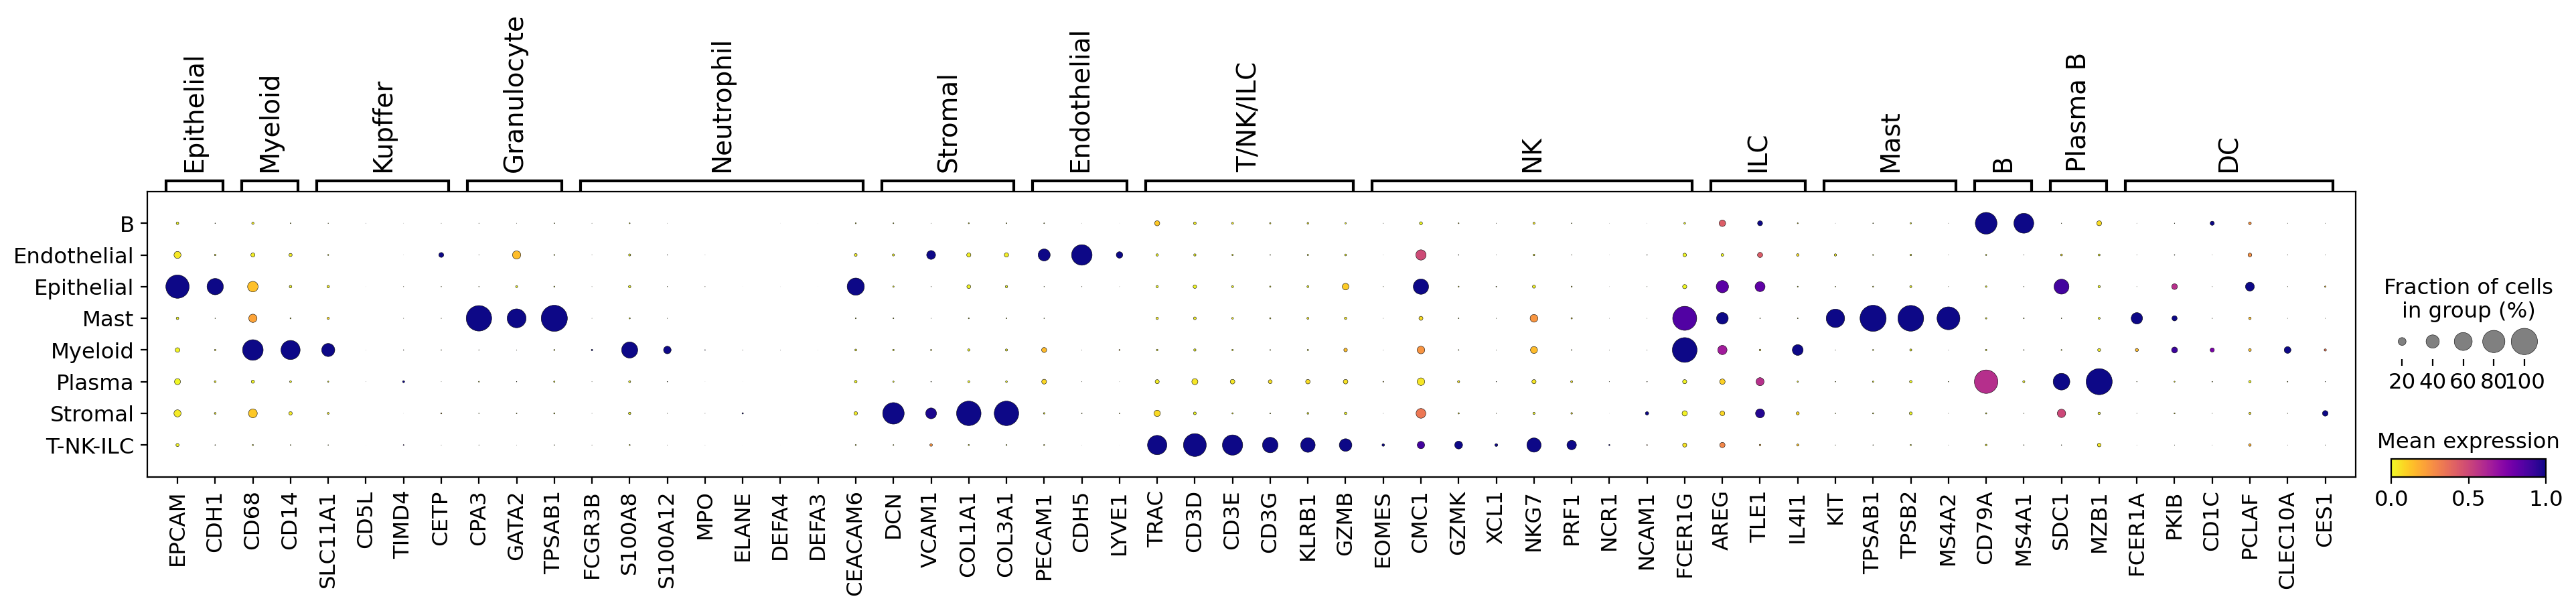

In [37]:
sc.pl.dotplot(
    adata,
    groupby="Annotation_scVI",
    use_raw=True,
    var_names=markers,
    cmap="plasma_r",
    standard_scale="var",
    vmin=0,
    vmax=1,
    colorbar_title="Mean expression",
    dendrogram=False,
    save="dotplot_mean_general.pdf",
    show=True,
)

In [38]:
from matplotlib.patches import Rectangle


def proportion_cells_patient(
    adata, groupby_labels, xlabel: str, ylabel: str, colors: dict, figname: str
):  # colors
    # compute proportion of cells within each group
    table2plot = (
        adata.reset_index()
        .groupby(groupby_labels)
        .size()
        .groupby(level=0)
        .apply(lambda x: x * 100 / x.sum())
        .unstack()
    )

    fig, ax = plt.subplots(
        nrows=1,
        ncols=1,
        sharey=False,
        sharex=False,
        dpi=DPI,
    )  # figsize=(4, 4))

    print(table2plot)
    table2plot.plot.bar(stacked=True, ax=ax, color=colors.values())  # , color=colors
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.grid(False, which="major", axis="both")  # removes major horizontal gridlinesd

    labels = list(colors.keys())
    l = [Rectangle((0, 0), 0, 0, color=color) for color in list(colors.values())]
    ax.legend(
        l,
        labels,
        loc="upper left",
        bbox_to_anchor=(1, 0.8),
        facecolor="white",
        edgecolor="white",
        ncol=1,
        borderaxespad=0.0,
        framealpha=0,
        frameon=False,
    )

    plt.savefig(FIG2SAVE.joinpath(figname), dpi=DPI, format="pdf", bbox_inches="tight")
    plt.show()

cell_source            SMC        KUL      Pelka        Che         Wu
Annotation_scVI                                                       
B                10.282698   2.294067  45.840735  20.717657  20.864843
Endothelial      19.895116  13.438217  61.520813   5.145854   0.000000
Epithelial       22.353176   2.510987  61.983620  13.142229   0.009988
Mast              0.347759   2.859351  73.029366  23.570325   0.193199
Myeloid          15.412128   2.189346  58.044762  17.008075   7.345689
Plasma            7.554648   1.016895  62.683161  11.550164  17.195132
Stromal          28.789572  21.266294  33.277467  16.666667   0.000000
T-NK-ILC         17.023491   1.872265  40.326452  24.449896  16.327896


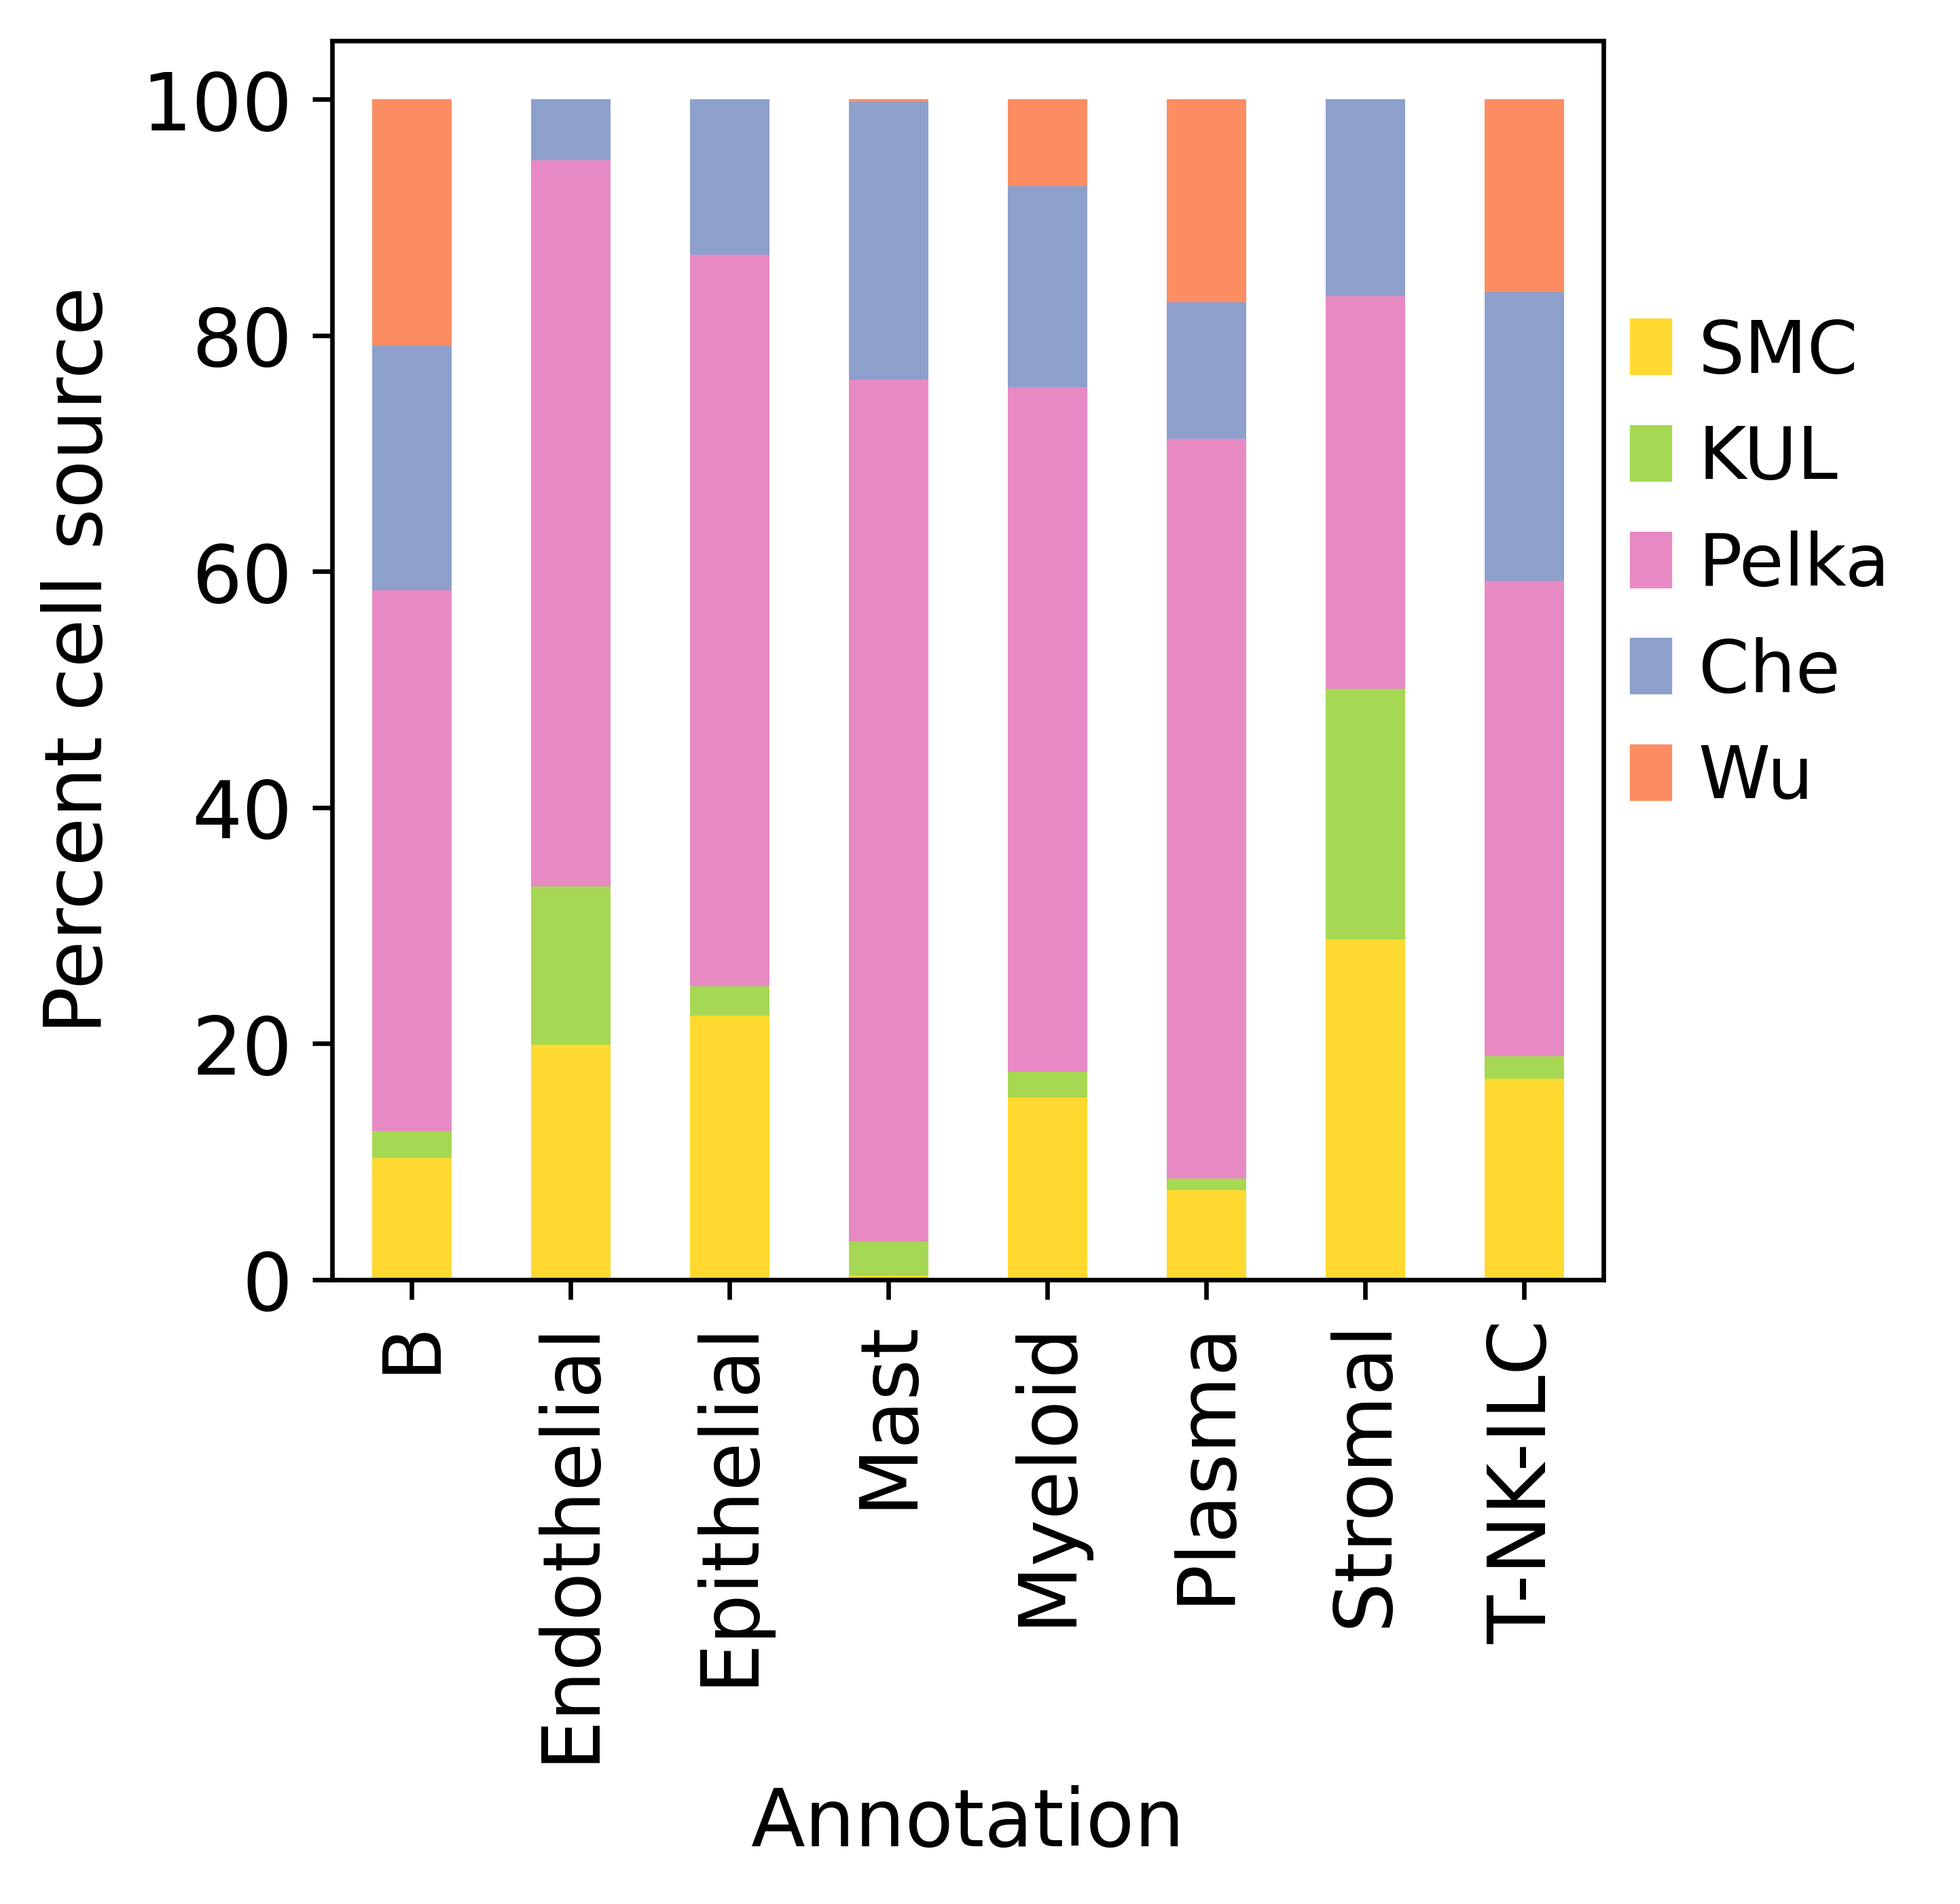

In [39]:
from collections import OrderedDict

color_dict = OrderedDict(
    zip(
        adata.obs["cell_source"].cat.categories.values.tolist(),
        adata.uns["cell_source_colors"],
    )
)

proportion_cells_patient(
    adata.obs,
    groupby_labels=["Annotation_scVI", "cell_source"],
    xlabel="Annotation",
    ylabel="Percent cell source",
    colors=color_dict,
    figname="annotation_cell_source.pdf",
)

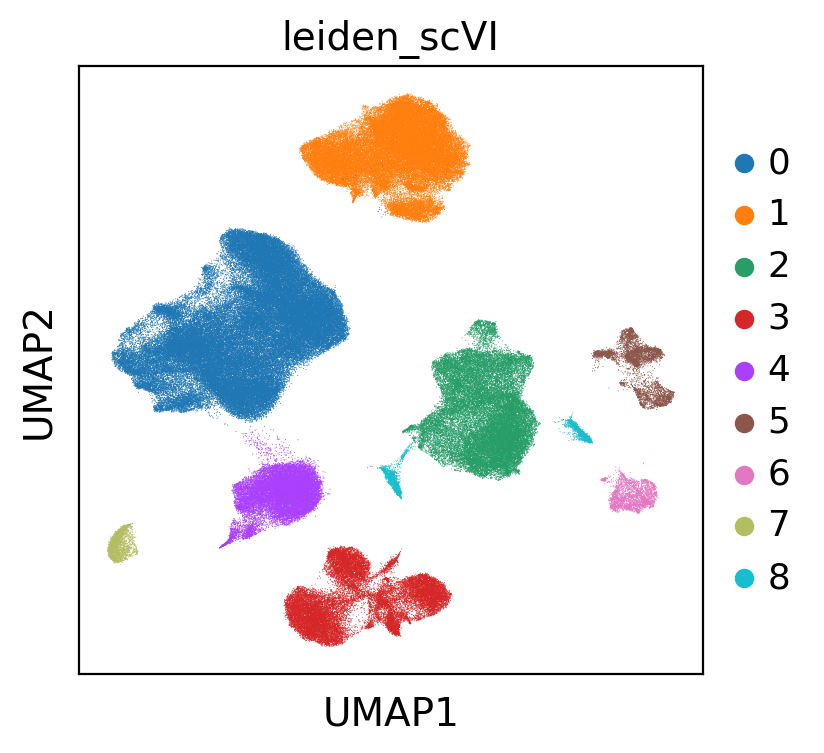

In [40]:
sc.pl.umap(adata, color="leiden_scVI", save="leiden_global.pdf")

### save object

In [41]:
adata.write(
    DIR2SAVE.joinpath(
        "SMC_KUL_Pelka_Che_Wu_CRC_integrated_scvi_hvg_final_annotations.h5ad"
    )
)

In [42]:
adata = sc.read_h5ad(
    DIR2SAVE.joinpath(
        "SMC_KUL_Pelka_Che_Wu_CRC_integrated_scvi_hvg_final_annotations.h5ad"
    )
)

In [43]:
adata.shape

(236820, 2000)

In [44]:
adata[adata.obs.Annotation_scVI == "T-NK-ILC"].shape

(94164, 2000)

In [45]:
adata[adata.obs.Annotation_scVI == "Myeloid"].shape

(36906, 2000)

In [46]:
adata[adata.obs.Annotation_scVI == "Stromal"].shape

(5370, 2000)

In [47]:
adata[adata.obs.Annotation_scVI == "Endothelial"].shape

(3051, 2000)

In [48]:
adata[adata.obs.Annotation_scVI == "Mast"].shape

(2588, 2000)

In [49]:
adata[adata.obs.Annotation_scVI == "B"].shape

(19703, 2000)

In [50]:
adata[adata.obs.Annotation_scVI == "Plasma"].shape

(24978, 2000)

In [51]:
adata[adata.obs.Annotation_scVI == "Epithelial"].shape

(50060, 2000)

#### for adata_raw only keep cells that are in adata 

In [52]:
adata_raw.shape

(249712, 38118)

In [53]:
# for the raw data keep only the cells that have been annotated
adata_raw = adata_raw[adata_raw.obs.index.isin(adata.obs.index)].copy()

In [54]:
adata_raw

AnnData object with n_obs × n_vars = 236820 × 38118
    obs: 'Patient', 'Sample', 'Cell_type', 'Cell_subtype', 'Tissue', 'Therapy', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'cell_source'
    var: 'n_cells_by_counts-Che', 'total_counts-Che', 'mean_counts-Che', 'pct_dropout_by_counts-Che', 'n_cells_by_counts-KUL', 'total_counts-KUL', 'mean_counts-KUL', 'pct_dropout_by_counts-KUL', 'n_cells_by_counts-Pelka', 'total_counts-Pelka', 'mean_counts-Pelka', 'pct_dropout_by_counts-Pelka', 'n_cells_by_counts-SMC', 'total_counts-SMC', 'mean_counts-SMC', 'pct_dropout_by_counts-SMC', 'n_cells_by_counts-Wu', 'total_counts-Wu', 'mean_counts-Wu', 'pct_dropout_by_counts-Wu', 'n_cells'
    uns: 'Therapy_colors', 'Tissue_colors', 'cell_source_colors'

In [55]:
adata_raw.obs = adata_raw.obs.merge(
    right=adata.obs[["Annotation_scVI", "Annotation_scVI_detailed"]],
    how="left",
    left_index=True,
    right_index=True,
)

In [56]:
adata_raw.obs

Patient       Sample         Cell_type  \
SMC01-T_AAACCTGGTCGCATAT-SMC            SMC01      SMC01-T  Epithelial cells   
SMC01-T_AAACGGGAGGGAAACA-SMC            SMC01      SMC01-T  Epithelial cells   
SMC01-T_AAAGATGAGGCCGAAT-SMC            SMC01      SMC01-T  Epithelial cells   
SMC01-T_AAAGATGTCACGACTA-SMC            SMC01      SMC01-T  Epithelial cells   
SMC01-T_AAAGATGTCCGTTGCT-SMC            SMC01      SMC01-T  Epithelial cells   
...                                       ...          ...               ...   
P17_Colon_T_TAAGCCATCTATCGCC-1-Wu  Wu2021_P17  P17_Colon_T                 B   
P17_Colon_T_TATACCTTCTAGTTCT-1-Wu  Wu2021_P17  P17_Colon_T                 B   
P17_Colon_T_TTCTGTAGTGCATTAC-1-Wu  Wu2021_P17  P17_Colon_T                 B   
P19_Colon_T_TCTAACTGTTGCTGAT-1-Wu  Wu2021_P19  P19_Colon_T                 B   
P20_Colon_T_ATCCCTGTCAAAGACA-1-Wu  Wu2021_P20  P20_Colon_T                 B   

                                           Cell_subtype Tissue Therapy  \
SMC01-T_AAACCTGGTCGCATAT-SMC                       CMS2    CRC   naive   
SMC01-T_AAACGGGAGGGAAACA-SMC                       CMS2    CRC   naive   
SMC01-T_AAAGATGAGGCCGAAT-SMC                       CMS2    CRC   naive   
SMC01-T_AAAGATGTCACGACTA-SMC                       CMS2    CRC   naive   
SMC01-T_AAAGATGTCCGTTGCT-SMC                       CMS2    CRC   naive   
...                                                 ...    ...     ...   
P17_Colon_T_TAAGCCATCTATCGCC-1-Wu  TCL1A+ Naive B cells    CRC   naive   
P17_Colon_T_TATACCTTCTAGTTCT-1-Wu  TCL1A+ Naive B cells    CRC   naive   
P17_Colon_T_TTCTGTAGTGCATTAC-1-Wu  AIM2+ Memory B cells    CRC   naive   
P19_Colon_T_TCTAACTGTTGCTGAT-1-Wu  AIM2+ Memory B cells    CRC     NAC   
P20_Colon_T_ATCCCTGTCAAAGACA-1-Wu  AIM2+ Memory B cells    CRC     NAC   

                                   doublet_score  predicted_doublet  \
SMC01-T_AAACCTGGTCGCATAT-SMC            0.089005              False   
SMC01-T_AAACGGGAGGGAAACA-SMC            0.121019              False   
SMC01-T_AAAGATGAGGCCGAAT-SMC            0.108911              False   
SMC01-T_AAAGATGTCACGACTA-SMC            0.103448              False   
SMC01-T_AAAGATGTCCGTTGCT-SMC            0.089005              False   
...                                          ...                ...   
P17_Colon_T_TAAGCCATCTATCGCC-1-Wu       0.214545              False   
P17_Colon_T_TATACCTTCTAGTTCT-1-Wu       0.171779              False   
P17_Colon_T_TTCTGTAGTGCATTAC-1-Wu       0.171779              False   
P19_Colon_T_TCTAACTGTTGCTGAT-1-Wu       0.023923              False   
P20_Colon_T_ATCCCTGTCAAAGACA-1-Wu       0.152941              False   

                                   n_genes_by_counts  total_counts  \
SMC01-T_AAACCTGGTCGCATAT-SMC                    5268       33750.0   
SMC01-T_AAACGGGAGGGAAACA-SMC                    1229        3752.0   
SMC01-T_AAAGATGAGGCCGAAT-SMC                    3319       15662.0   
SMC01-T_AAAGATGTCACGACTA-SMC                    2990       16813.0   
SMC01-T_AAAGATGTCCGTTGCT-SMC                    1926        5295.0   
...                                              ...           ...   
P17_Colon_T_TAAGCCATCTATCGCC-1-Wu                515         880.0   
P17_Colon_T_TATACCTTCTAGTTCT-1-Wu                532        1056.0   
P17_Colon_T_TTCTGTAGTGCATTAC-1-Wu                757        1686.0   
P19_Colon_T_TCTAACTGTTGCTGAT-1-Wu                642        1457.0   
P20_Colon_T_ATCCCTGTCAAAGACA-1-Wu                389         718.0   

                                   total_counts_mt  pct_counts_mt  \
SMC01-T_AAACCTGGTCGCATAT-SMC                2957.0       8.761481   
SMC01-T_AAACGGGAGGGAAACA-SMC                 358.0       9.541578   
SMC01-T_AAAGATGAGGCCGAAT-SMC                1140.0       7.278764   
SMC01-T_AAAGATGTCACGACTA-SMC                 909.0       5.406530   
SMC01-T_AAAGATGTCCGTTGCT-SMC                 337.0       6.364494   
...                                            ...            ...   
P17_Colon_T

In [57]:
adata_raw.X[0:5, 0:5].todense()

matrix([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]], dtype=float32)

In [58]:
np.max(adata_raw.X)

59020.0

In [59]:
adata_raw.write(
    DIR2SAVE.joinpath(
        "SMC_KUL_Pelka_Che_Wu_CRC_integrated_scvi_hvg_final_annotations_raw.h5ad"
    )
)